# RFM analysis

In [1]:
import pandas as pd
import numpy as np
# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
orders = pd.read_csv('RFM_ht_data.csv',sep=',',low_memory=False, parse_dates=['InvoiceDate'])

In [3]:
orders.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [5]:
last_date = orders.InvoiceDate.max()

In [6]:
rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency
                                        'CustomerCode': lambda x: len(x),      # Frequency 
                                        'Amount': lambda x: x.sum()}) # Monetary Value 

In [7]:
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'CustomerCode': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [8]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88


In [9]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])

In [10]:
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [11]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [12]:
rfmSegmentation = rfmTable.loc[:]

In [13]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = (rfmSegmentation.R_Quartile.map(str)
                            + rfmSegmentation.F_Quartile.map(str)
                            + rfmSegmentation.M_Quartile.map(str))

In [14]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


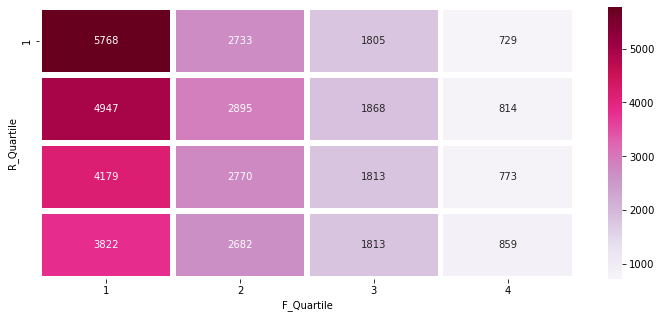

In [15]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="PuRd", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);